In [1]:
import pandas as pd
import janitor
from IPython.display import display

import warnings

warnings.filterwarnings("ignore")

import numpy as np
from scipy.stats import percentileofscore

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook", font_scale=1.35, style="whitegrid", palette="dark")

from utilities import save_mpl_fig
from matplotlib.lines import Line2D

## Prep

In [2]:
df = (
    pd.read_csv("../data/6.3m-ind-domain-data.csv.gz")
    .rename_column("visit_duration", "duration")
    .assign(
        duration_min=lambda df_: df_["duration"] / 60,
        duration_hr=lambda df_: df_["duration"] / 3600,
    )
    # ==================================================
    # Merge to VT
    .merge(
        (pd.read_csv("../data/yg_virustotal_dat.csv")),
        how="left",
        left_on="private_domain",
        right_on="filename",
        validate="m:1",
    )
    .assign(
        malicious_bool=lambda df_: np.where(df_["malicious"] >= 2, True, False),
        malicious_min=lambda df_: df_["malicious_bool"] * df_["duration_min"],
        malicious_hr=lambda df_: df_["malicious_bool"] * df_["duration_hr"],
        suspicious_bool=lambda df_: df_["suspicious"].astype("bool"),
    )
    # ==================================================
    # Merge to ind demo (n = 1200)
    .merge(
        (
            pd.read_csv("../data/profile.csv").assign(
                # https://github.com/themains/bad_domains/blob/main/data/codebook.pdf
                gender_lab=lambda df_: df_["gender"].replace({1: "Male", 2: "Female"}),
                race_lab=lambda df_: df_["race"].replace(
                    {
                        1: "White",
                        2: "Black",
                        3: "Hispanic",
                        4: "Asian",
                        5: "Other",
                        6: "Other",
                        7: "Other",
                        8: "Other",
                    }
                ),
                educ_lab=lambda df_: df_["educ"].replace(
                    {
                        1: "HS or Below",
                        2: "HS or Below",
                        3: "Some college",
                        4: "Some college",
                        5: "College",
                        6: "Postgrad",
                    }
                ),
                agegroup_lab=lambda df_: pd.cut(
                    df_["birthyr"],
                    bins=[1930, 1957, 1972, 1997, 2022],
                    labels=["65+", "50--65", "25--50", "<25"],
                ),
            )
        ),
        how="left",
        on="caseid",
        validate="m:1",
    )
)
display(df.head())
df.info()

,caseid,private_domain,category,visit_time_local,duration,duration_min,duration_hr,filename,harmless,malicious,...,educ,pid3,pid7,presvote20post,inputstate,region,gender_lab,race_lab,educ_lab,agegroup_lab
0,205323077,google.com,Search Engines and Portals,2022-05-31 23:52:37,2,0.033333,0.000556,google.com,70.0,0.0,...,3,2,7,2,45,3,Male,White,Some college,50--65
1,205323077,coupons.com,"Business, Shopping",2022-06-01 01:07:35,457,7.616667,0.126944,coupons.com,68.0,0.0,...,3,2,7,2,45,3,Male,White,Some college,50--65
2,205323077,google.com,Business,2022-06-01 01:15:12,55,0.916667,0.015278,google.com,70.0,0.0,...,3,2,7,2,45,3,Male,White,Some college,50--65
3,205323077,coupons.com,"Business, Shopping",2022-06-01 01:16:07,2225,37.083333,0.618056,coupons.com,68.0,0.0,...,3,2,7,2,45,3,Male,White,Some college,50--65
4,205323077,google.com,Search Engines and Portals,2022-06-01 04:38:10,10,0.166667,0.002778,google.com,70.0,0.0,...,3,2,7,2,45,3,Male,White,Some college,50--65


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6297382 entries, 0 to 6297381
Data columns (total 35 columns):
 #   Column            Dtype   
---  ------            -----   
 0   caseid            int64   
 1   private_domain    object  
 2   category          object  
 3   visit_time_local  object  
 4   duration          int64   
 5   duration_min      float64 
 6   duration_hr       float64 
 7   filename          object  
 8   harmless          float64 
 9   malicious         float64 
 10  suspicious        float64 
 11  undetected        float64 
 12  timeout           float64 
 13  forcepoint        object  
 14  sophos            object  
 15  bitdefender       object  
 16  comodo            object  
 17  alphamnt          object  
 18  malicious_bool    bool    
 19  malicious_min     float64 
 20  malicious_hr      float64 
 21  suspicious_bool   bool    
 22  birthyr           float64 
 23  gender            int64   
 24  race              int64   
 25  educ              

In [3]:
df_mal_visits = df.query("malicious_bool==1").reset_index(drop=True)
assert (df_mal_visits["duration_min"] == df_mal_visits["malicious_min"]).all()
display(df_mal_visits.head(3))
df_mal_visits.info()

,caseid,private_domain,category,visit_time_local,duration,duration_min,duration_hr,filename,harmless,malicious,...,educ,pid3,pid7,presvote20post,inputstate,region,gender_lab,race_lab,educ_lab,agegroup_lab
0,205323077,promogiveawayus.com,NaN,2022-06-15 02:28:02,46,0.766667,0.012778,promogiveawayus.com,57.0,10.0,...,3,2,7,2,45,3,Male,White,Some college,50--65
1,205323077,xanderpath.com,Parked,2022-06-15 14:39:30,3,0.050000,0.000833,xanderpath.com,64.0,2.0,...,3,2,7,2,45,3,Male,White,Some college,50--65
2,205323077,only-goodthings.com,Parked,2022-06-15 14:48:21,34,0.566667,0.009444,only-goodthings.com,60.0,6.0,...,3,2,7,2,45,3,Male,White,Some college,50--65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23677 entries, 0 to 23676
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   caseid            23677 non-null  int64   
 1   private_domain    23677 non-null  object  
 2   category          10846 non-null  object  
 3   visit_time_local  23677 non-null  object  
 4   duration          23677 non-null  int64   
 5   duration_min      23677 non-null  float64 
 6   duration_hr       23677 non-null  float64 
 7   filename          23677 non-null  object  
 8   harmless          23677 non-null  float64 
 9   malicious         23677 non-null  float64 
 10  suspicious        23677 non-null  float64 
 11  undetected        23677 non-null  float64 
 12  timeout           23677 non-null  float64 
 13  forcepoint        19733 non-null  object  
 14  sophos            16694 non-null  object  
 15  bitdefender       14478 non-null  object  
 16  comodo            545 

In [4]:
df_nonmal_visits = (
    df
    .query("malicious==0")
    .query("suspicious==0")
    .reset_index(drop=True)
)
display(df_nonmal_visits.head(3))
df_nonmal_visits.info()

,caseid,private_domain,category,visit_time_local,duration,duration_min,duration_hr,filename,harmless,malicious,...,educ,pid3,pid7,presvote20post,inputstate,region,gender_lab,race_lab,educ_lab,agegroup_lab
0,205323077,google.com,Search Engines and Portals,2022-05-31 23:52:37,2,0.033333,0.000556,google.com,70.0,0.0,...,3,2,7,2,45,3,Male,White,Some college,50--65
1,205323077,coupons.com,"Business, Shopping",2022-06-01 01:07:35,457,7.616667,0.126944,coupons.com,68.0,0.0,...,3,2,7,2,45,3,Male,White,Some college,50--65
2,205323077,google.com,Business,2022-06-01 01:15:12,55,0.916667,0.015278,google.com,70.0,0.0,...,3,2,7,2,45,3,Male,White,Some college,50--65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6002879 entries, 0 to 6002878
Data columns (total 35 columns):
 #   Column            Dtype   
---  ------            -----   
 0   caseid            int64   
 1   private_domain    object  
 2   category          object  
 3   visit_time_local  object  
 4   duration          int64   
 5   duration_min      float64 
 6   duration_hr       float64 
 7   filename          object  
 8   harmless          float64 
 9   malicious         float64 
 10  suspicious        float64 
 11  undetected        float64 
 12  timeout           float64 
 13  forcepoint        object  
 14  sophos            object  
 15  bitdefender       object  
 16  comodo            object  
 17  alphamnt          object  
 18  malicious_bool    bool    
 19  malicious_min     float64 
 20  malicious_hr      float64 
 21  suspicious_bool   bool    
 22  birthyr           float64 
 23  gender            int64   
 24  race              int64   
 25  educ              

## Malicious

### Summarize

In [5]:
100 * (len(df_mal_visits) / len(df))

0.37598163808388946

In [6]:
percentiles = [5, 10, 25, 50, 75, 90, 95, 99]
df_summ = (
    df_mal_visits[["duration"]]
    .describe(percentiles=[p / 100 for p in percentiles])
    .astype(int)
    .T.drop(columns="count")
    .applymap(lambda x: f"{x:,}")
    .reset_index(names="var")
    #     .assign(
    #         var=lambda df: df["var"].replace(
    #             {
    #                 "malicious_bool": "\\# unique malicious sites",
    #                 "malicious_visits": "\\# visits to malicious sites",
    #                 "malicious_min": "\\# minutes spent on malicious sites",
    #                 "suspicious_bool": "\# unique suspicious sites",
    #             }
    #         )
    #     )
)
df_summ

,var,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max
0,duration,39,339,0,0,1,1,4,17,51,109,439,"21,601"


In [7]:
# 1 second is the 17th percentile
# `weak' This kind corresponds to the definition of a cumulative distribution function.
# A percentileofscore of 80% means that 80%of values are less than or equal to the provided score.
percentileofscore(df_mal_visits["duration"], 1, kind="weak")

29.784178738860497

In [8]:
# 7000 visits are 1 second or less
len(df_mal_visits.query("duration<=1"))

7052

In [9]:
# How many % are x seconds or less
thresholds = range(1, 10)  # Adjust this range as needed

# Calculate and store results in a dictionary
cumulative_percentages = {}
for t in thresholds:
    percentage = 100 * len(df_mal_visits.query(f"duration <= {t}")) / len(df_mal_visits)
    cumulative_percentages[t] = percentage
    print(f"{percentage:.2f}% of visits are {t} seconds or less")

cumulative_percentages

29.78% of visits are 1 seconds or less
39.49% of visits are 2 seconds or less
45.51% of visits are 3 seconds or less
50.25% of visits are 4 seconds or less
54.30% of visits are 5 seconds or less
57.52% of visits are 6 seconds or less
60.32% of visits are 7 seconds or less
62.81% of visits are 8 seconds or less
65.03% of visits are 9 seconds or less


{1: 29.784178738860497,
 2: 39.48557672002365,
 3: 45.51252270135575,
 4: 50.25129872872408,
 5: 54.29741943658403,
 6: 57.519956075516326,
 7: 60.32436541791612,
 8: 62.80778814883642,
 9: 65.0293533809182}

### Plot

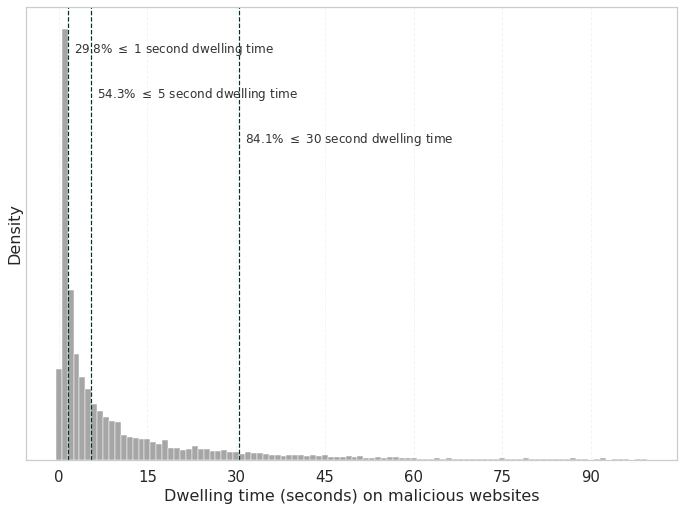

In [10]:
# plot
_scale = 0.8
_aspect_ratio = (12, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

sns.histplot(
    df_mal_visits.query("duration < 100")["duration"],
    color=".5",
    stat="density",
    alpha=0.7,
    discrete=True,
    ax=ax,
)

plt.xlabel("Dwelling time (seconds) on malicious websites", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xticks(np.arange(0, 100, 15))
plt.yticks([])
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()

save_mpl_fig("../figs/dwelling-time-malicious-visits")

# ====================================================================
# Annotate
# Annotate 1 second
_secs = 1
_x = 100 * len(df_mal_visits.query(f"duration<={_secs}")) / len(df_mal_visits)
ax.axvline(_secs + 0.5, color="#032f30", linestyle="--", linewidth=1.2)
ax.text(
    _secs + 1.5,  # x position
    ax.get_ylim()[1] * 0.9,  # Y position, slightly below the top
    f"{_x:.1f}% $\\leq$ {_secs} second dwelling time",
    color=".2",
    fontsize=12,
    ha="left",  # Align text to the right of the line
)
# Annotate 5 seconds
_secs = 5
_x = 100 * len(df_mal_visits.query(f"duration<={_secs}")) / len(df_mal_visits)
ax.axvline(_secs + 0.5, color="#032f30", linestyle="--", linewidth=1.2)
ax.text(
    _secs + 1.5,  # x position
    ax.get_ylim()[1] * 0.8,  # Y position, slightly below the top
    f"{_x:.1f}% $\\leq$ {_secs} second dwelling time",
    color=".2",
    fontsize=12,
    ha="left",  # Align text to the right of the line
)

# Annotate 30 seconds
_secs = 30
_x = 100 * len(df_mal_visits.query(f"duration<={_secs}")) / len(df_mal_visits)
ax.axvline(_secs + 0.5, color="#032f30", linestyle="--", linewidth=1.2)
ax.text(
    _secs + 1.5,  # x position
    ax.get_ylim()[1] * 0.7,  # Y position, slightly below the top
    f"{_x:.1f}% $\\leq$ {_secs} second dwelling time",
    color=".2",
    fontsize=12,
    ha="left",  # Align text to the right of the line
)

save_mpl_fig("../figs/dwelling-time-malicious-visits-annotated")

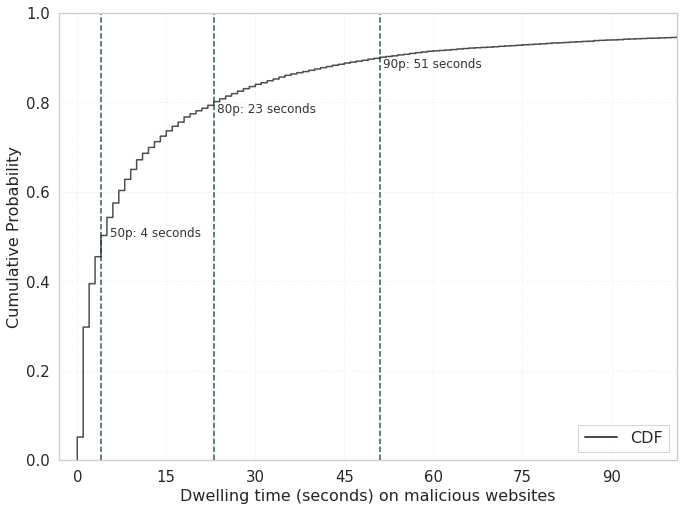

In [11]:
# Plot
_scale = 0.8
_aspect_ratio = (12, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

# Plot the CDF using Seaborn's ecdfplot
sns.ecdfplot(data=df_mal_visits, x="duration", color=".3", ax=ax)
ax.set_xlim(-3, 101)

plt.xlabel("Dwelling time (seconds) on malicious websites", fontsize=16)
plt.ylabel("Cumulative Probability", fontsize=16)
plt.xticks(np.arange(0, 100, 15))
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()

# legend
custom_legend = [
    Line2D([0], [0], color=".3", lw=2, label="CDF"),
]

ax.legend(
    handles=custom_legend, loc="lower right", fontsize=16, frameon=True, fancybox=False
)

save_mpl_fig("../figs/dwelling-time-malicious-visits-CDF")

# ====================================================
# Annotate
# Find the duration at 50% cumulative probability
_cum_p = 50
_duration_cum_p = np.percentile(df_mal_visits["duration"], _cum_p)

ax.axvline(_duration_cum_p, color="#032f30", linestyle="--", alpha=0.8, linewidth=1.5)
ax.text(
    _duration_cum_p + 1.5,
    _cum_p / 100,  # Y position at 50% cumulative probability
    f"{_cum_p}p: {int(_duration_cum_p)} seconds",  # Format as integer
    color=".2",
    fontsize=12,
    ha="left",
)

# Find the duration at 80% cumulative probability
_cum_p = 80
_duration_cum_p = np.percentile(df_mal_visits["duration"], _cum_p)

ax.axvline(_duration_cum_p, color="#032f30", linestyle="--", alpha=0.8, linewidth=1.5)
ax.text(
    _duration_cum_p + 0.5,
    _cum_p / 100,  # Y position at 50% cumulative probability
    f"{_cum_p}p: {int(_duration_cum_p)} seconds",  # Format as integer
    color=".2",
    fontsize=12,
    ha="left",
    va="top",
)

# Find the duration at 90% cumulative probability
_cum_p = 90
_duration_cum_p = np.percentile(df_mal_visits["duration"], _cum_p)

ax.axvline(_duration_cum_p, color="#032f30", linestyle="--", alpha=0.8, linewidth=1.5)
ax.text(
    _duration_cum_p + 0.5,
    _cum_p / 100,  # Y position at 50% cumulative probability
    f"{_cum_p}p: {int(_duration_cum_p)} seconds",  # Format as integer
    color=".2",
    fontsize=12,
    ha="left",
    va="top",
)

save_mpl_fig("../figs/dwelling-time-malicious-visits-CDF-annotated")

## Non-malicious (flags = 0)

### Summarize

In [12]:
100 * (len(df_nonmal_visits) / len(df))

95.32340582165732

In [13]:
percentiles = [5, 10, 25, 50, 75, 90, 95, 99]
df_summ = (
    df_nonmal_visits[["duration"]]
    .describe(percentiles=[p / 100 for p in percentiles])
    .astype(int)
    .T.drop(columns="count")
    .applymap(lambda x: f"{x:,}")
    .reset_index(names="var")
    #     .assign(
    #         var=lambda df: df["var"].replace(
    #             {
    #                 "malicious_bool": "\\# unique malicious sites",
    #                 "malicious_visits": "\\# visits to malicious sites",
    #                 "malicious_min": "\\# minutes spent on malicious sites",
    #                 "suspicious_bool": "\# unique suspicious sites",
    #             }
    #         )
    #     )
)
df_summ

,var,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max
0,duration,37,264,0,0,1,2,7,23,67,125,445,"86,258"


In [14]:
# 1 second is the 17th percentile
# `weak' This kind corresponds to the definition of a cumulative distribution function.
# A percentileofscore of 80% means that 80%of values are less than or equal to the provided score.
percentileofscore(df_nonmal_visits["duration"], 1, kind="weak")

18.34178233477636

In [15]:
# 7000 visits are 1 second or less
len(df_nonmal_visits.query("duration<=1"))

1101035

In [16]:
# How many % are x seconds or less
thresholds = range(1, 10)  # Adjust this range as needed

# Calculate and store results in a dictionary
cumulative_percentages = {}
for t in thresholds:
    percentage = 100 * len(df_nonmal_visits.query(f"duration <= {t}")) / len(df_nonmal_visits)
    cumulative_percentages[t] = percentage
    print(f"{percentage:.2f}% of visits are {t} seconds or less")

cumulative_percentages

18.34% of visits are 1 seconds or less
26.84% of visits are 2 seconds or less
33.47% of visits are 3 seconds or less
38.93% of visits are 4 seconds or less
43.52% of visits are 5 seconds or less
47.47% of visits are 6 seconds or less
50.87% of visits are 7 seconds or less
53.91% of visits are 8 seconds or less
56.61% of visits are 9 seconds or less


{1: 18.34178233477636,
 2: 26.841720447805127,
 3: 33.470956186189994,
 4: 38.92622190119108,
 5: 43.52028418363922,
 6: 47.46629075815122,
 7: 50.87372242552282,
 8: 53.90909928386029,
 9: 56.60793762459647}

### Plot

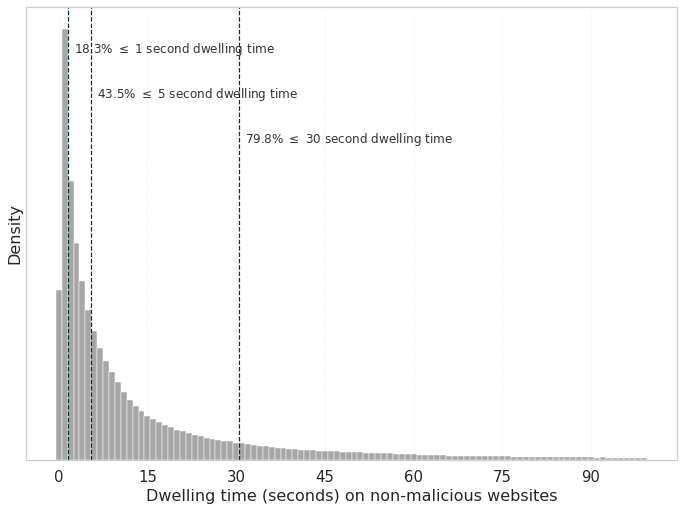

In [17]:
# plot
_scale = 0.8
_aspect_ratio = (12, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

sns.histplot(
    df_nonmal_visits.query("duration < 100")["duration"],
    color=".5",
    stat="density",
    alpha=0.7,
    discrete=True,
    ax=ax,
)

plt.xlabel("Dwelling time (seconds) on non-malicious websites", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xticks(np.arange(0, 100, 15))
plt.yticks([])
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()

save_mpl_fig("../figs/dwelling-time-nonmalicious-visits")

# ====================================================================
# Annotate
# Annotate 1 second
_secs = 1
_x = 100 * len(df_nonmal_visits.query(f"duration<={_secs}")) / len(df_nonmal_visits)
ax.axvline(_secs + 0.5, color="#032f30", linestyle="--", linewidth=1.2)
ax.text(
    _secs + 1.5,  # x position
    ax.get_ylim()[1] * 0.9,  # Y position, slightly below the top
    f"{_x:.1f}% $\\leq$ {_secs} second dwelling time",
    color=".2",
    fontsize=12,
    ha="left",  # Align text to the right of the line
)
# Annotate 5 seconds
_secs = 5
_x = 100 * len(df_nonmal_visits.query(f"duration<={_secs}")) / len(df_nonmal_visits)
ax.axvline(_secs + 0.5, color="#032f30", linestyle="--", linewidth=1.2)
ax.text(
    _secs + 1.5,  # x position
    ax.get_ylim()[1] * 0.8,  # Y position, slightly below the top
    f"{_x:.1f}% $\\leq$ {_secs} second dwelling time",
    color=".2",
    fontsize=12,
    ha="left",  # Align text to the right of the line
)

# Annotate 30 seconds
_secs = 30
_x = 100 * len(df_nonmal_visits.query(f"duration<={_secs}")) / len(df_nonmal_visits)
ax.axvline(_secs + 0.5, color="#032f30", linestyle="--", linewidth=1.2)
ax.text(
    _secs + 1.5,  # x position
    ax.get_ylim()[1] * 0.7,  # Y position, slightly below the top
    f"{_x:.1f}% $\\leq$ {_secs} second dwelling time",
    color=".2",
    fontsize=12,
    ha="left",  # Align text to the right of the line
)

save_mpl_fig("../figs/dwelling-time-nonmalicious-visits-annotated")

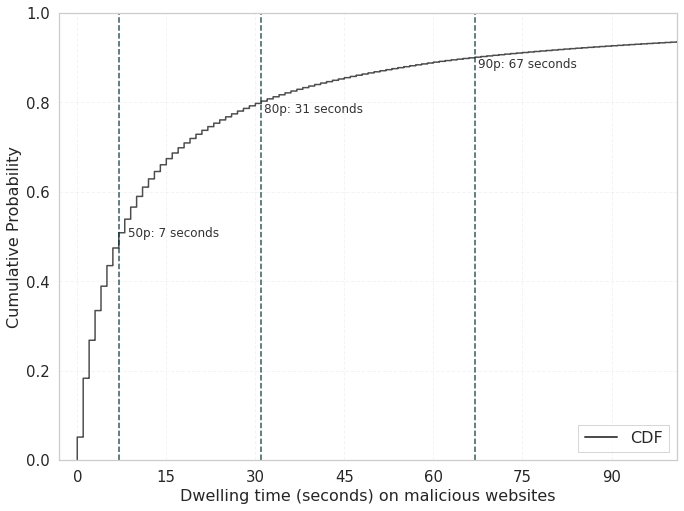

In [18]:
# Plot
_scale = 0.8
_aspect_ratio = (12, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

# Plot the CDF using Seaborn's ecdfplot
sns.ecdfplot(data=df_nonmal_visits, x="duration", color=".3", ax=ax)
ax.set_xlim(-3, 101)

plt.xlabel("Dwelling time (seconds) on malicious websites", fontsize=16)
plt.ylabel("Cumulative Probability", fontsize=16)
plt.xticks(np.arange(0, 100, 15))
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()

# legend
custom_legend = [
    Line2D([0], [0], color=".3", lw=2, label="CDF"),
]

ax.legend(
    handles=custom_legend, loc="lower right", fontsize=16, frameon=True, fancybox=False
)

save_mpl_fig("../figs/dwelling-time-nonmalicious-visits-CDF")

# ====================================================
# Annotate
# Find the duration at 50% cumulative probability
_cum_p = 50
_duration_cum_p = np.percentile(df_nonmal_visits["duration"], _cum_p)

ax.axvline(_duration_cum_p, color="#032f30", linestyle="--", alpha=0.8, linewidth=1.5)
ax.text(
    _duration_cum_p + 1.5,
    _cum_p / 100,  # Y position at 50% cumulative probability
    f"{_cum_p}p: {int(_duration_cum_p)} seconds",  # Format as integer
    color=".2",
    fontsize=12,
    ha="left",
)

# Find the duration at 80% cumulative probability
_cum_p = 80
_duration_cum_p = np.percentile(df_nonmal_visits["duration"], _cum_p)

ax.axvline(_duration_cum_p, color="#032f30", linestyle="--", alpha=0.8, linewidth=1.5)
ax.text(
    _duration_cum_p + 0.5,
    _cum_p / 100,  # Y position at 50% cumulative probability
    f"{_cum_p}p: {int(_duration_cum_p)} seconds",  # Format as integer
    color=".2",
    fontsize=12,
    ha="left",
    va="top",
)

# Find the duration at 90% cumulative probability
_cum_p = 90
_duration_cum_p = np.percentile(df_nonmal_visits["duration"], _cum_p)

ax.axvline(_duration_cum_p, color="#032f30", linestyle="--", alpha=0.8, linewidth=1.5)
ax.text(
    _duration_cum_p + 0.5,
    _cum_p / 100,  # Y position at 50% cumulative probability
    f"{_cum_p}p: {int(_duration_cum_p)} seconds",  # Format as integer
    color=".2",
    fontsize=12,
    ha="left",
    va="top",
)

save_mpl_fig("../figs/dwelling-time-nonmalicious-visits-CDF-annotated")